<H2> Parameter Estimation Using PINNS <H2>

<h4> Simulate Plasma(Simplistic) <h4>

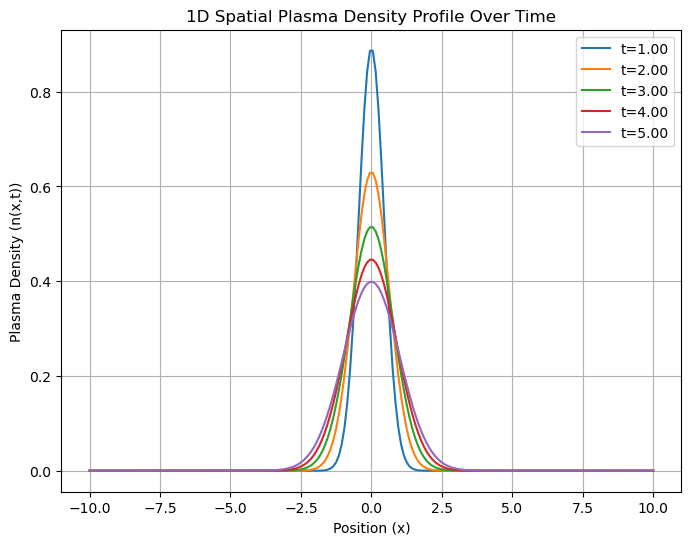

In [450]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate plasma density as a function of space and time
def plasma_density(x, t, n0, D, x0):
    return (n0 / np.sqrt(4 * np.pi * D * t)) * np.exp(-(x - x0)**2 / (4 * D * t))

# Parameters
n0 = 1.0      # Initial peak plasma density
x0 = 0.0      # Initial peak position
D = 0.1       # Diffusion coefficient
x_min, x_max = -10, 10  # Spatial range
t_min, t_max = 1.0, 5.0  # Time range (avoid t=0 to prevent division by zero)

# Generate spatial points and time points
x = np.linspace(x_min, x_max, 200)  # 200 spatial points
t = np.linspace(t_min, t_max, 5)    # 5 time points

# Create an n by m array to store plasma density values
plasma_density_array = np.zeros((len(x), len(t)))

# Calculate the plasma density for each time point and store it in the array
for i, t_ in enumerate(t):
    plasma_density_array[:, i] = plasma_density(x, t_, n0, D, x0)

# Plot the plasma density at different times
plt.figure(figsize=(8, 6))
for i, t_ in enumerate(t):
    plt.plot(x, plasma_density_array[:, i], label=f't={t_:.2f}')

# Labels and title
plt.xlabel('Position (x)')
plt.ylabel('Plasma Density (n(x,t))')
plt.title('1D Spatial Plasma Density Profile Over Time')
plt.grid(True)
plt.legend()
plt.show()

<h4> Train PINN for Parameter Estimation with a modified driven Burger's equation <h4>

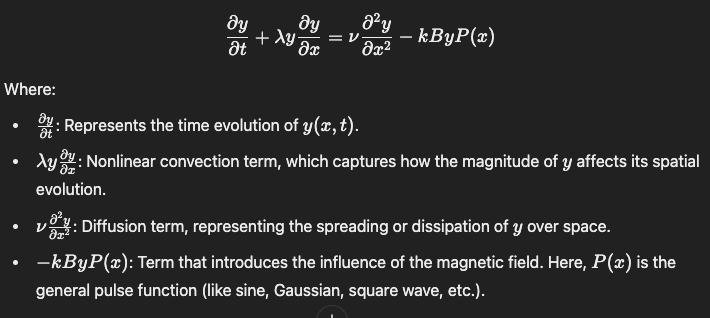

In [451]:
# torch and numpy imports
import torch
import torch.nn as nn                    
import numpy as np

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [452]:
X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X = torch.tensor(X.T).float()
T = torch.tensor(T.T).float()
y_real = torch.tensor(plasma_density_array).float()

In [453]:
def plot3D(X, T, y):
    X = X.detach().numpy()
    T = T.detach().numpy()
    y = y.detach().numpy()

    #     2D
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    cm = ax1.contourf(T, X, y, 20,cmap="viridis")
    fig.colorbar(cm, ax=ax1) # Add a colorbar to a plot
    ax1.set_title('u(x,t)')
    ax1.set_xlabel('t')
    ax1.set_ylabel('x')
    ax1.set_aspect('equal')
        #     3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot_surface(T, X, y,cmap="viridis")
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.set_zlabel('u(x,t)')
    fig.tight_layout()

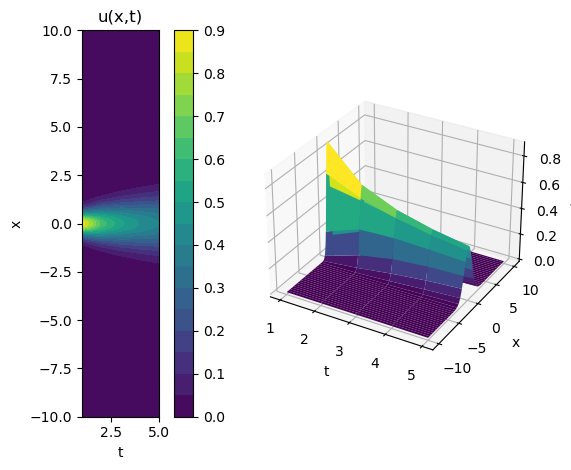

In [454]:
plot3D(X, T, y_real) 

In [455]:
X_test = X.reshape(-1,1)
T_test = T.reshape(-1,1)
Y_test = y_real.reshape(-1,1) 

In [456]:
total_points=len(x)*len(t)

Nf = 400  # Nf: Number of collocation points 

# Obtain random points of our PDE measurements y(x,t)
id_f = np.random.choice(total_points, Nf, replace=False)# Randomly chosen points for Interior
X_train_Nu = X_test[id_f]
T_train_Nu = T_test[id_f]
Y_train_Nu = Y_test[id_f]

In [457]:
print("We have",total_points,"points. We will select",X_train_Nu.shape[0],"points to train our model.")

We have 1000 points. We will select 400 points to train our model.


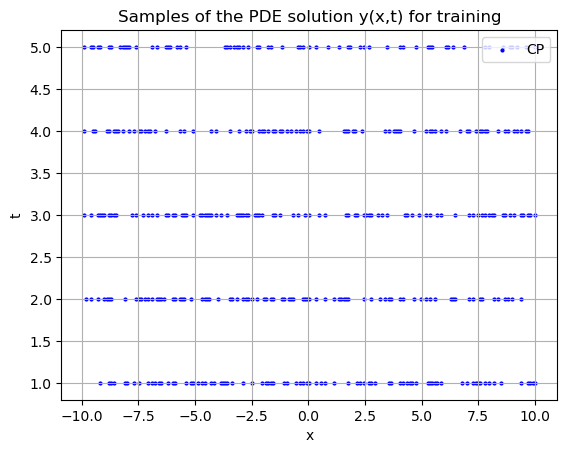

In [458]:
# visualize collocation points for 2D input space (x, t)
plt.figure()
plt.scatter(X_train_Nu.detach().numpy(), T_train_Nu.detach().numpy(),
            s=4., c='blue', marker='o', label='CP')
plt.title('Samples of the PDE solution y(x,t) for training')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.show()
plt.show(block=True)

In [459]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train_Nu.requires_grad=True
T_train_Nu.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train_Nu, 't':T_train_Nu, 'y':Y_train_Nu}, name='train')
# test dataset
test_data = DictDataset({'x': X_test, 't':T_test, 'y':Y_test}, name='test')

# torch dataloaders
batch_size = X_train_Nu.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

In [460]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# neural net to solve the PDE problem bounded in the PDE domain 
net = blocks.MLP(insize=2, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)

# symbolic wrapper of the neural net
pde_net = Node(net, ['x', 't'], ['y_hat'], name='net')

In [461]:
# evaluate forward pass on the train data
net_out = pde_net(train_data.datadict)
net_out['y_hat'].shape

torch.Size([400, 1])

In [462]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
y = variable('y')           # PDE measurements from the dataset
y_hat = variable('y_hat')  # PDE solution generated as the output of a neural net (pde_net)
t = variable('t')          # temporal domain
x = variable('x')          # spatial domain
# trainable parameters with initial values
lamb = variable(torch.nn.Parameter(torch.tensor(2.0)), display_name='lambda')       # trainable PDE parameter lambda
nu = variable(torch.nn.Parameter(torch.tensor(0.01)), display_name='nu')             # trainable PDE parameter nu
k = variable(torch.nn.Parameter(torch.tensor(0.2)), display_name='k')  # trainable PDE parameter k
B = 0.45  #Fixed magnetic field

In [463]:
#Define a pulse type

import torch

# Define a general pulse function
def pulse_function(x, B, pulse_type="sine"):
    """
    Generalized pulse function for the magnetic field influence.

    Parameters:
    - x: The spatial variable (can be a tensor in the context of PINN)
    - B: The magnetic field strength (constant)
    - pulse_type: Type of pulse ("sine", "square", "gaussian", etc.)

    Returns:
    - Pulse-modulated value
    """
    if pulse_type == "sine":
        return torch.sin(B * x)
    elif pulse_type == "square":
        return torch.sign(torch.sin(B * x))  # Example of a square wave
    elif pulse_type == "gaussian":
        return torch.exp(-((x - 0.5)**2) / (2 * (0.1)**2))  # Example Gaussian pulse
    # Add more pulse types as needed
    else:
        raise ValueError(f"Unknown pulse type: {pulse_type}")

In [475]:
import torch

# Get the symbolic derivatives
dy_dt = y_hat.grad(t)       # Time derivative of y_hat
dy_dx = y_hat.grad(x)       # Spatial derivative of y_hat
d2y_d2x = dy_dx.grad(x)     # Second spatial derivative of y_hat

# Apply the pulse function (default to sine wave)
pulse_term = pulse_function(x, B, pulse_type="sine")  # You can change "sine" to another type

# Update the PINN form with fixed magnetic field B and coupling constant k
f_pinn = dy_dt + lamb * y_hat * dy_dx - nu * d2y_d2x + k * B * y_hat * pulse_term

In [476]:
# scaling factor for better convergence
scaling = 1000.

# PDE CP loss
ell_1 = (f_pinn == 0.)^2

# PDE supervised learning loss
ell_2 = scaling*(y_hat == y)^2 

# ell_3 = output constraints to bound the PINN solution in the PDE output domain [-1.0, 1.0]
con_1 = (y_hat <= 1.0)^2
con_2 = (y_hat >= -1.0)^2

In [477]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# create Neuromancer optimization loss
pinn_loss = PenaltyLoss(objectives=[ell_1, ell_2], constraints=[con_1, con_2])

# construct the PINN optimization problem
problem = Problem(nodes=[pde_net],      # list of nodes (neural nets) to be optimized
                  loss=pinn_loss,       # physics-informed loss function
                  grad_inference=True   # argument for allowing computation of gradients at the inference time)
                 )

In [478]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
epochs = 2000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    device=device
)

In [479]:
# Train PINN
best_model = trainer.train()

epoch: 0  train_loss: 0.007773210294544697
epoch: 200  train_loss: 0.005797574296593666
epoch: 400  train_loss: 0.0040140217170119286
epoch: 600  train_loss: 0.002722359960898757
epoch: 800  train_loss: 0.0019205535063520074
epoch: 1000  train_loss: 0.0014472290640696883
epoch: 1200  train_loss: 0.003645922290161252
epoch: 1400  train_loss: 0.0009745382703840733
epoch: 1600  train_loss: 0.0008198742289096117
epoch: 1800  train_loss: 0.0007763979956507683


In [480]:
# load best trained model
problem.load_state_dict(best_model)

<All keys matched successfully>

In [481]:
# evaluate trained PINN on test data
PINN = problem.nodes[0].cpu()
y1 = PINN(test_data.datadict)['y_hat']

# arrange data for plotting
y_pinn = y1.reshape(shape=[200,5]).detach().cpu()

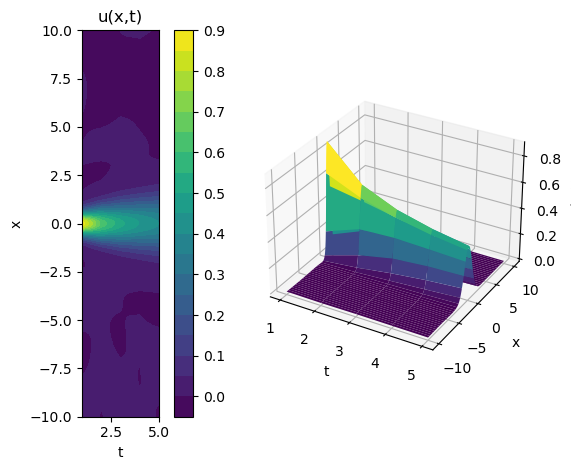

In [482]:
# plot PINN solution
plot3D(X, T, y_pinn)

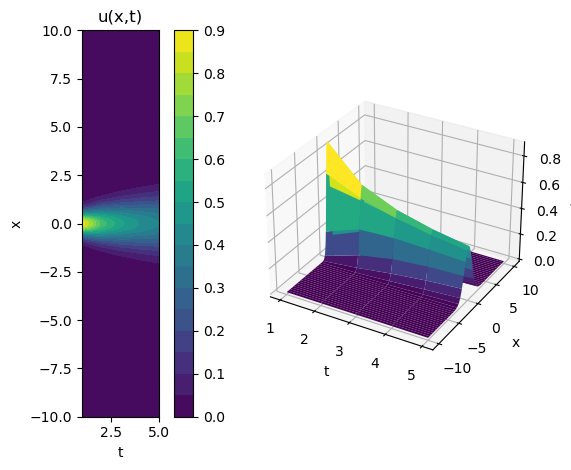

In [483]:
# plot exact PDE solution
plot3D(X, T, y_real)

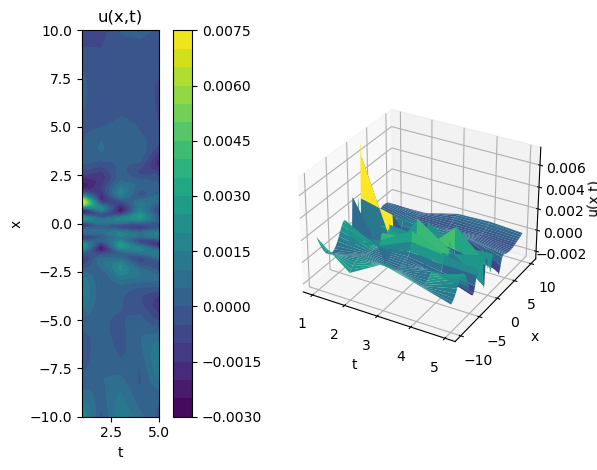

In [484]:
# plot residuals PINN - exact PDE
plot3D(X, T, y_pinn-y_real)

In [485]:
print('Estimated parameter lambda = ', float(lamb.value))
print('Estimated parameter nu = ', float(nu.value))
print('Estimated parameter k = ', float(k.value))

Estimated parameter lambda =  0.05244382098317146
Estimated parameter nu =  0.080165795981884
Estimated parameter k =  0.04724273085594177


<h4> Use Estimated Parameters from PINN-s to train  Model Predictive Control <h4>

In [486]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Parameters
Nx = 80               # Number of spatial points 
Nt = 60               # Number of time steps 
L = 10.0              # Length of the domain
dx = L / (Nx - 1)     # Spatial resolution
dt = 0.005            # Time step for stability
nu_fixed = 0.080165795981884       # Fixed magnetic viscosity
lambda_fixed = 0.05244382098317146    # Fixed nonlinear parameter
k = 0.04724273085594177              # Coefficient for magnetic field influence

# Define a general pulse function
def pulse_function(x, B, pulse_type="sine"):
    """
    Generalized pulse function for the magnetic field influence.

    Parameters:
    - x: The spatial variable
    - B: The magnetic field strength (constant)
    - pulse_type: Type of pulse ("sine", "square", "gaussian", etc.)

    Returns:
    - Pulse-modulated value
    """
    if pulse_type == "sine":
        return np.sin(B * x)
    elif pulse_type == "square":
        return np.sign(np.sin(B * x))  # Example of a square wave
    elif pulse_type == "gaussian":
        return np.exp(-((x - 0.5)**2) / (2 * (0.1)**2))  # Example Gaussian pulse
    else:
        raise ValueError(f"Unknown pulse type: {pulse_type}")

def cost_function(magnetic_field, initial_density, target_state):
    """Cost function for plasma magnetic control."""
    n = np.zeros((Nx, Nt))  # Initialize density array

    # Solve the Burgers' equation with the current magnetic field
    n = burgers_solver(n, initial_density, Nx, Nt, dx, dt, nu_fixed, lambda_fixed, magnetic_field)
    
    final_density = n[:, -1]  # Final density at the last time step
    
    # Compute loss using L2 norm
    loss = np.sum((final_density - target_state) ** 2)  # Calculate loss
    return loss

def burgers_solver(n, initial_density, Nx, Nt, dx, dt, nu, lambda_param, B):
    """Updated Burgers' equation solver with magnetic field dependence."""
    n[:, 0] = initial_density  # Set initial state (density)

    for n_idx in range(Nt - 1):
        n_prev = n[:, n_idx]

        # Compute spatial derivatives using central differences
        dn_dx = (n_prev[2:] - n_prev[:-2]) / (2 * dx)  # ∂n/∂x for interior points
        dn_dx_full = np.zeros(Nx)  # Use NumPy array for full size
        dn_dx_full[1:-1] = dn_dx  # Assign computed values to correct indices

        # Nonlinear term: n * lambda * ∂n/∂x
        nonlinear_term = n_prev * lambda_param * dn_dx_full

        # Magnetic field influence term using the pulse function
        x_array = np.linspace(0, L, Nx)  # Create an array for spatial coordinates
        magnetic_field_term = pulse_function(x_array, B) * n_prev  # Apply pulse function

        # Update equation for plasma dynamics
        n[1:-1, n_idx + 1] = (
            n_prev[1:-1]
            - dt * nonlinear_term[1:-1]  # Nonlinear interaction
            + nu * dt / dx**2 * (n_prev[2:] - 2 * n_prev[1:-1] + n_prev[:-2])  # Viscosity term
            - dt * magnetic_field_term[1:-1]  # Magnetic field influence
        )

        # Apply periodic boundary conditions
        n[0, n_idx + 1] = n[Nx - 2, n_idx + 1]
        n[Nx - 1, n_idx + 1] = n[1, n_idx + 1]

    return n

def generate_initial_and_target(Nx, Nt, dx, dt, nu_fixed, lambda_fixed):
    """Generate initial and target states for the plasma dynamics."""
    n = np.zeros((Nx, Nt))  # Initialize density array

    # Set a very narrow Gaussian initial state
    sigma = 0.1  # Width of the Gaussian (narrower than before)
    initial_density = np.exp(-((np.linspace(0, L, Nx) - L / 2) ** 2) / (2 * sigma ** 2))

    # Solve the Burgers' equation for this initial state
    n = burgers_solver(n, initial_density, Nx, Nt, dx, dt, nu_fixed, lambda_fixed, 0)  # Use zero for initial magnetic field

    return initial_density, n[:, -1]  # Return initial and target state as NumPy arrays

# Generate initial and target states
initial_state, target_state = generate_initial_and_target(Nx, Nt, dx, dt, nu_fixed, lambda_fixed)

# Initialize the magnetic field
magnetic_field = np.random.uniform(0.5, 1.0, size=(1,))  # Starting magnetic field value as an array

# Store magnetic field history
magnetic_field_history = []

def collect_magnetic_field(magnetic_field):
    """Callback function to collect magnetic field values."""
    magnetic_field_history.append(magnetic_field[0])  # Store current value

# Optimize the magnetic field to match the target state
result = minimize(
    cost_function, 
    magnetic_field, 
    args=(initial_state, target_state), 
    method='Nelder-Mead', 
    callback=collect_magnetic_field
)

# Check for convergence
if result.success:
    optimized_magnetic_field = result.x[0]  # Optimized magnetic field
    print(f"Optimization converged to {optimized_magnetic_field:.4f} with message: {result.message}")
else:
    print(f"Optimization did not converge: {result.message}")

# Calculate final density after optimization
final_density = burgers_solver(
    np.zeros((Nx, Nt)), 
    initial_state, 
    Nx, 
    Nt, 
    dx, 
    dt, 
    nu_fixed, 
    lambda_fixed, 
    optimized_magnetic_field
)[:, -1]  # Convert final density back to NumPy array


Optimization converged to 0.6274 with message: Optimization terminated successfully.


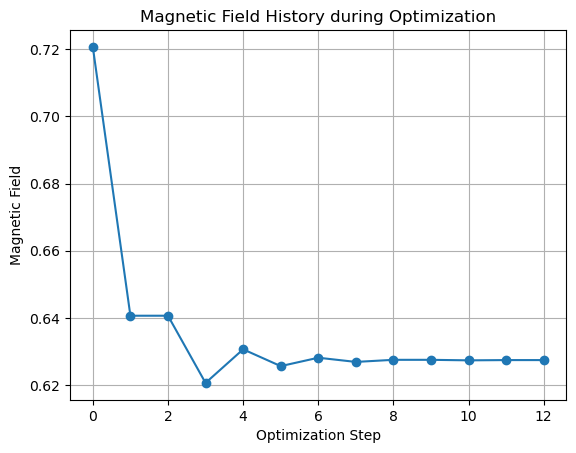

In [487]:
# Plot the magnetic field history
plt.plot(magnetic_field_history, marker='o')
plt.title('Magnetic Field History during Optimization')
plt.xlabel('Optimization Step')
plt.ylabel('Magnetic Field')
plt.grid()
plt.show()

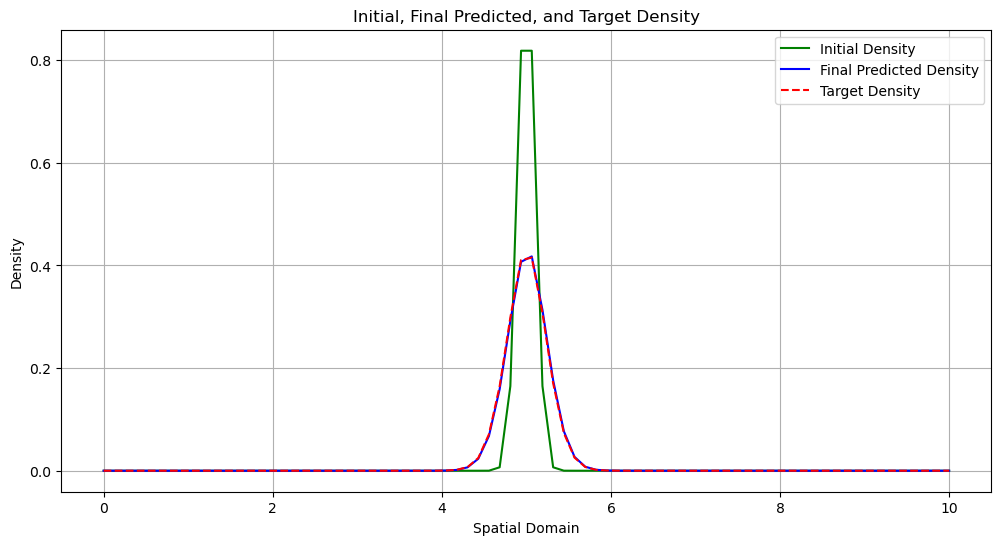

In [488]:
# Assuming the code above is defined up to the optimization step

# After generating initial and target states and performing the optimization
# We will plot the last predicted density against the target state

# Convert outputs to a NumPy array for easier handling
# Note: Assuming 'outputs' contains the simulation results, if not, please use final_density
outputs = np.array(magnetic_field_history)  # Example: if you want to visualize magnetic field history

# Take the last output for plotting (you can also plot multiple if needed)
last_final_density = final_density  # Use the final density after optimization

# Plotting
plt.figure(figsize=(12, 6))

# Plotting the initial density
initial_density = initial_state  # Use the initial density generated earlier
plt.plot(np.linspace(0, L, Nx), initial_density, label='Initial Density', color='green')

# Plotting the final predicted density
plt.plot(np.linspace(0, L, Nx), last_final_density, label='Final Predicted Density', color='blue')

# Plotting the target density
plt.plot(np.linspace(0, L, Nx), target_state, label='Target Density', color='red', linestyle='dashed')

# Adding labels and title
plt.xlabel('Spatial Domain')
plt.ylabel('Density')
plt.title('Initial, Final Predicted, and Target Density')
plt.legend()
plt.grid()
plt.show()
